# このノートの目次


# 結果のまとめ


In [91]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import pandas as pd

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '../conf/'))
sys.path.append(os.path.join(current_dir, '../crawl/'))
sys.path.append(os.path.join(current_dir, '../data_preparing/'))
sys.path.append(os.path.join(current_dir, 'analyzer_conf/'))

# my module
import loader
import boatrace_crawler_conf
import analyzer_conf

In [72]:
# 過去のレース結果をdfとして取得
the_merged_df = loader.make_merged_df()
# dfをソート
the_merged_df = the_merged_df.sort_values(["date", "venue", "raceNumber"])
print(the_merged_df)

            date venue  raceNumber weather windDir  windPow  waveHight ruler  \
11083 2019-01-01   　津　           1       晴      無風        0          0   抜き　   
11084 2019-01-01   　津　           4       晴      東　        1          1   逃げ　   
11085 2019-01-01   　津　           5       晴      東　        1          1   逃げ　   
11086 2019-01-01   　津　           6       晴      東　        2          1   逃げ　   
11087 2019-01-01   　津　           7       晴      東　        2          1   逃げ　   
11088 2019-01-01   　津　           8       晴      東　        2          1   抜き　   
11089 2019-01-01   　津　           9       晴      東　        1          1   逃げ　   
11090 2019-01-01   　津　          10       晴      東　        1          1   逃げ　   
11091 2019-01-01   　津　          11       曇      無風        0          0   逃げ　   
11092 2019-01-01   　津　          12       曇      北西        3          2   逃げ　   
11023 2019-01-01   下　関           1       曇      西　        7          7   逃げ　   
11024 2019-01-01   下　関           2      

In [73]:
# logistic regressionを利用した学習
def make_df_for_analyze(merged_df, fv_list, column_list_label, odds_list):
    
    """
    parameters
        fv_list: dfのうち、特徴量として用いるカラム名のリスト
        column_list_label: dfのうち、labelとして用いるカラム名のリスト
    """
    
    # ラベルの数を変数名にしておく。labelと特徴量を分けるときに使う
    num_labels = len(column_list_label)

    # 解析用dfを作成
    fv_label_odds_df = the_merged_df[fv_list + column_list_label + odds_list]
    
    # nanを含む行を削除
    fv_label_odds_df = fv_label_odds_df.dropna()
    
    # oddsはないバージョンのdf
    fv_label_df = fv_label_odds_df[fv_list + column_list_label ]
    
    # クラスカラムを，A1 =0, A2 = 1のように数字に変換する
    class_dict = {"A1": 0, "A2":1, "B1": 2, "B2": 3}
    for key, value in class_dict.items():
        fv_label_df.replace(key, value, inplace = True)

    # なぜかdtypeがstrになっちゃうのでintに戻す
    fv_labe_df = fv_label_df.astype(float)

    # ラベルをbooleanに変換
    fv_label_df = analyzer_conf.make_label_boolean_ver1(
        fv_label_df, column_list_label)
    print("解析用dfの行数は.{0}".format(len(fv_label_df)))

    # 特徴量を標準化
    fv_label_df = analyzer_conf.standerdize_feature_values(
        fv_label_df, column_list_label)
        
    return fv_label_df, fv_label_odds_df
    

def learn_logistic_regression(for_analysis_df):
    
    """
    1枠が1着になるかどうか？2枠以降に関しては3着以内に入るかどうか？を scikit-lernのlogistic regressionを用いて学習する。
    複数のラベルをリストとして入力することが可能で、戻り値はそれぞれのlabelに対して学習を行なった結果のモデルを各要素にもつリスト
    
    return
        clf_list: 各ラベルについて学習したモデルのlist
    
    TODO
        ラベルの作成方法などもinput parameterとして指定できた方がいい。
        むしろregressionの方法もinputにして超汎用的な関数を外側に作るか？
    
    """
   
    # 学習用データとテストデータに分ける
    train_size = int(len(for_analysis_df) * train_data_ratio)
    train_data = for_analysis_df[:train_size].values
    test_data = for_analysis_df[train_size:].values

    # 特徴量部分のarray
    train_x = train_data[:, :-num_labels]
    test_x = test_data[:, :-num_labels]

    # ロジスティック回帰を行なった結果得られるオブジェクトをリストに格納
    clf_list  = []

    for i, column_label in enumerate(column_list_label):
        # ラベルを指定
        train_t = train_data[:, - num_labels + i]

        # ロジスティック回帰
        clf = LogisticRegression()
        clf.fit(train_x, train_t)

        clf_list.append(clf)
    
    return clf_list


# ----------input-------------
# 解析に使う特徴量カラム
fv_list = []
for i in range(1, 7):
    # 各枠のレーサーのクラス
    fv_list.append("class_{0}".format(i))
    # 各枠の平均ST
    fv_list.append("aveST_frame{0}".format(i))
    # 連帯率
    fv_list.append("placeRate_frame{0}".format(i))
    # 展示順位
    fv_list.append("exhibitionRank_{0}".format(i))
    # 展示タイム
    fv_list.append("exhibitionTime_{0}".format(i))

# 解析に使うラベルカラム: 今回は一枠が一着になるかどうか？を予測
column_list_label = ["rank_{0}".format(i) for i in range(1,7)]

# 回収率計算に使用するオッズラベルのリスト
odds_list =  ["win", "winOdds", 
             "place_1", "placeOdds_1",
             "place_2", "placeOdds_2",
             "exacta", "exactaOdds",
             "quinella", "quinellaOdds",
             "wide_1", "wideOdds_1", 
             "wide_2", "wideOdds_2",
             "wide_3", "wideOdds_3",
             "trifecta", "trifectaOdds",
             "trio", "trioOdds"]

# データのうち、教師データとして使う割合（残りをテストデータとして用いる）
train_data_ratio = 0.7

# --------------------------------

# main
fv_label_df, fv_label_odds_df = make_df_for_analyze(the_merged_df, fv_list, column_list_label, odds_list)
clf_list = learn_logistic_regression(fv_label_df)

# 

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


解析用dfの行数は.22924


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

1号艇についてtrainデータを使った正解率は0.6488221363579708,
           testデータを使った正解率は0.6497528351264903
切片は[0.20324089]
class_1 -0.43925572380363354 

aveST_frame1 -0.11454729135121161 

placeRate_frame1 0.2758256116345356 

exhibitionRank_1 -0.23288887897194063 

exhibitionTime_1 -0.4582340471219351 

class_2 0.05594213318201606 

aveST_frame2 -0.0463622880170838 

placeRate_frame2 -0.08823305281593585 

exhibitionRank_2 -0.07713722758217917 

exhibitionTime_2 0.1708005728418735 

class_3 0.022564962739594224 

aveST_frame3 0.011963639277078265 

placeRate_frame3 -0.03843747716512725 

exhibitionRank_3 -0.008582779443450393 

exhibitionTime_3 0.11288310629350785 

class_4 0.06780232752469717 

aveST_frame4 0.02263076112746617 

placeRate_frame4 -0.06094588998855041 

exhibitionRank_4 -0.009278227565360125 

exhibitionTime_4 0.14125661893887817 

class_5 0.04997985161649746 

aveST_frame5 0.027761203968298735 

placeRate_frame5 -0.04116149098870475 

exhibitionRank_5 0.019604306321590194 

exhibitionT

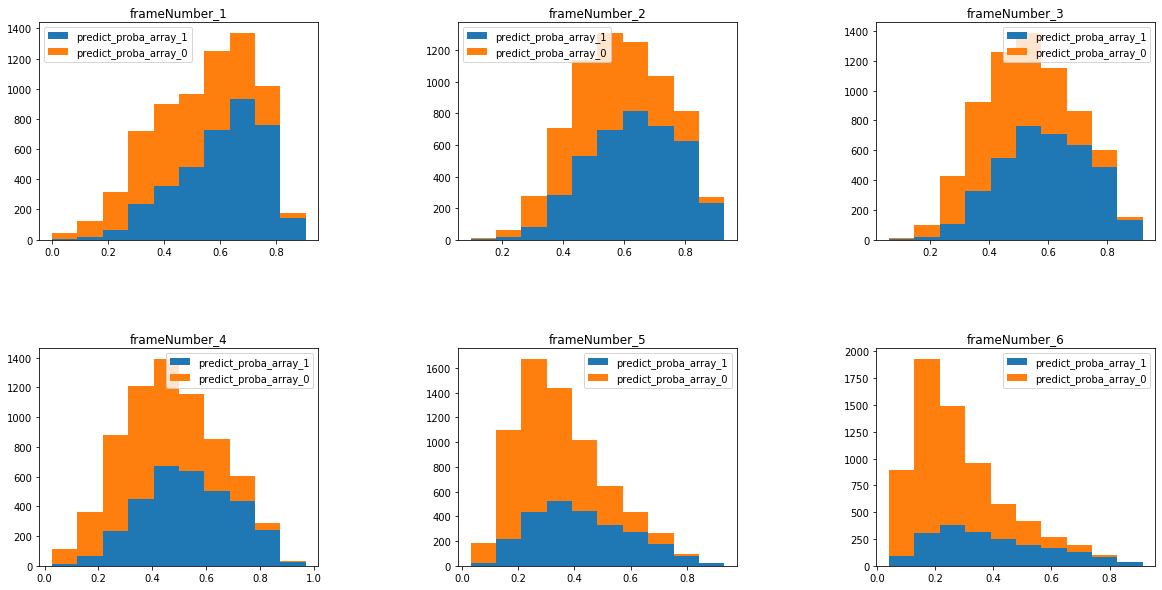

In [89]:
"""
上のセルで学習したclfを用いて色々と解析する。
今このセルで行なっている解析は
1. 各labelについて正解率を計算
2. 最適化された結果の切片および各係数を表示
3. テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成

"""
# 描画用の枠を用意

plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

# 回収率計算用に、[predict_proba_array, test_t]を各要素にもつリストを作成
predict_proba_array_list = []

for i, clf in enumerate(clf_list):
    train_t = train_data[:, - num_labels + i]
    test_t = test_data[:, - num_labels + i]
    
    # 正解率を計算
    train_score = clf.score(train_x, train_t)
    test_score = clf.score(test_x, test_t)
    print("{2}号艇についてtrainデータを使った正解率は{0},\n \
          testデータを使った正解率は{1}".format(train_score, test_score, i + 1))

    # 最適化された結果の切片と重みを取得
    intercept =clf.intercept_
    coef = clf.coef_
    print("切片は{0}".format(intercept))
    for j in range (coef.shape[1]):
        print(fv_list[j], coef[0, j], "\n")

    # テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成
    predict_proba_array = clf.predict_proba(test_x)
    
    # listに格納しておく
    predict_proba_array_list.append(predict_proba_array[:, 1])

    # 結果が1 (1枠が一着 , 2枠以降が3着以内) だったものの推定確率
    predict_proba_array_1 = predict_proba_array[:, 1][test_t==1]

    # 結果が0 (1枠以外が一着, 1枠以外の場合は4着以降) だったものの推定確率
    predict_proba_array_0 = predict_proba_array[:, 1][test_t==0]

    # 積み上げヒストグラムを作成
    title = "frameNumber_{0}".format(i + 1)
    labels = {'predict_proba_array_1', 'predict_proba_array_0'}
    plt.subplot(2, 3, i+1)
    plt.hist([predict_proba_array_1, predict_proba_array_0], histtype="barstacked", label=labels)
    plt.title(title)
    plt.legend()
plt.show()


# 考察
- 正解率はいずれのラベルに対しても6割から7割程度にとどまるが、test dataとtraining dataで同程度の正解率をだす。
確率ごとにプロットをしてみると、
- predict_probaが小さい時は実際に0ラベル、predict_probaが大きい時は実際に1ラベルであることがかなり多くなっている。
- 正解率を下げているのは実際に判断が難しいところ（0.3 < predict_proba < 0.7くらいの場所） であり、predict_probaが高いところ、低いところを抽出して用いることで十分に予測器として使用可能
- 1着以外が1位になる，荒れるレースの予測や、1着を1枠に固定し、2, 3を高いprobabilityを示すものでbox買するといったオプションが考えられる。

そこで、以下のセルにおいては掛け方を色々してみた時の回収率計算を行う。

In [140]:
# 計算用dfを作成
# 6列目までが上の解析によって求めた確率(1号艇が1位になる率, 2-6号艇が3位以内に入る確率)
# 7列目以降にオッズ関係の値を格納

for_calc_refund_rate_df = pd.DataFrame(np.vstack(predict_proba_array_list).T, columns=["PredProb_{0}".format(i) for i in range(1, 7)])
for odds_column_name in odds_list:
    # TODO intで入れられるものはintで。無理なものはとりあえずobjectのままで格納
    for_calc_refund_rate_df[odds_column_name] = fv_label_odds_df[odds_column_name][train_size:].values

print(for_calc_refund_rate_df)

      PredProb_1  PredProb_2  PredProb_3  PredProb_4  PredProb_5  PredProb_6  \
0       0.445698    0.478218    0.784438    0.590273    0.154732    0.277574   
1       0.794171    0.473937    0.606734    0.439552    0.310195    0.204121   
2       0.293182    0.835892    0.697309    0.157471    0.133091    0.665531   
3       0.296542    0.772169    0.645702    0.081635    0.568657    0.459971   
4       0.513337    0.843091    0.390910    0.231916    0.131775    0.675944   
5       0.644900    0.393986    0.671047    0.220512    0.726900    0.181534   
6       0.588458    0.363779    0.421030    0.733169    0.677047    0.097381   
7       0.608218    0.453553    0.465021    0.236841    0.676182    0.441156   
8       0.722391    0.520711    0.675112    0.208682    0.344669    0.294984   
9       0.713541    0.325306    0.740489    0.428503    0.365161    0.266935   
10      0.626781    0.631392    0.604433    0.590822    0.134848    0.270835   
11      0.344740    0.851979    0.492428

In [130]:
# 確率0.8以上のときのみ、1に単勝賭けした時の回収率
bet = sum(for_calc_refund_rate_df["PredProb_1"] > 0.8)

return_boolean = (for_calc_refund_rate_df["PredProb_1"] > 0.8) & (for_calc_refund_rate_df["win"] == "1")
return_ = sum(for_calc_refund_rate_df["winOdds"][return_boolean])

print("的中率は{0}".format(sum(return_boolean) / bet))
print("回収率は{0}".format(return_ / (bet * 100)))

290
的中率は0.8379310344827586
回収率は0.9493103448275862


In [152]:
# 1号艇の勝率0.8以上の時、他の艇で3位以内率がx割超えがあった場合に、1-XY..の形で2連単bet

income = 0

for index, row in for_calc_refund_rate_df.iterrows():
    if (row["PredProb_1"] > 0.8):
        for j in range(2, 7):
            if row["PredProb_{0}".format(j)] > 0.8:
                bet_num = "1-{0}".format(j)
                if row["exacta"] == bet_num:
                    income = income + row["exactaOdds"]
                else:
                    income = income - 100
print(income)

200


# 考察
2号艇から5号艇に関するthresholdを色々と変えてみると、
0.4: 3780
0.5: 6370
0.6: 4510
0.7: 1120
0.8: 200
となり、条件をきつくしすぎても、bet数が少なくなって効率が下がるということがわかる。
この方針でやるなら0.5-0.6ぐらいの条件が良さそう。

ただし、何れにしても回収率プラスになるのでまじすばらしい

In [ ]:
# 1号艇の勝率0.8以上の時、他の艇で3位以内率8割超えが二つ以上あった場合に、1-XY..(box)の形で3連単bet

income = 0

for index, row in for_calc_refund_rate_df.iterrows():
    if (row["PredProb_1"] > 0.8):
        for j in range(2, 7):
            if row["PredProb_{0}".format(j)] > 0.8:
                if row
                bet_num = "1-{0}".format(j)
                if row["exacta"] == bet_num:
                    income = income + row["exactaOdds"]
                else:
                    income = income - 100
print(income)

In [ ]:
# 1の確率が0.2以下のとき、2-6号艇の値が0.8以上のものに対して単勝bet
